# Inferring labels

This notebook shows how to construct reasoning chains to infer the target label set. It is helpful when you don't know which ontology might be presented in the dataset of interest. The typical approach is to look at each individual example and add a new category to the ontology when met. But this manual approach can be automated. 

To give an example, let's load a dataset of news:

In [2]:
import pandas as pd
from datasets import load_dataset

ds = load_dataset('ag_news', 'default')
df = pd.DataFrame(data=ds['train'][:1000]['text'], columns=['text'])
df

,text
0,Wall St. Bears Claw Back Into the Black (Reute...
1,Carlyle Looks Toward Commercial Aerospace (Reu...
2,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,Iraq Halts Oil Exports from Main Southern Pipe...
4,"Oil prices soar to all-time record, posing new..."
...,...
995,U.S. Stocks Rebound as Oil Prices Ease NEW YO...
996,Dollar Rises Vs Euro After Asset Data NEW YOR...
997,Bikes Bring Internet to Indian Villagers (AP) ...
998,Celebrity Chefs Are Everywhere in Vegas By ADA...


# Label creation agent

The first agent receives raw texts from the news dataset and determines the best label set for the given target. 

For example:

In [8]:
target = 'help analysts identify the primary reason for changes in the stock market.'

To create the possible label set that fits this target, agent's reasoning path consists of 2 stages:

1. `onto_creator` - create possible candidates for labels;
2. `onto_merger` - merge label candidates with similar semantics

In [6]:
from adala.agents import Agent
from adala.runtimes import OpenAIChatRuntime
from adala.skills import AnalysisSkill, LinearSkillSet


onto_creator = AnalysisSkill(
    name='onto_creator',
    instructions=f'''
The target is: {target}. 
Given the list of examples separated by '## Example <id>', assign not more than 5 categories that best describe the target for the given examples.
Don't repeat semantically similar categories if a single category can describe multiple examples.
Output only a list of assigned categories separated by a newline; don't output any additional text.''',
    input_template='''
## Example {i}
Text: {text}\n\n''',
    output_template='{categories}',
    input_separator='\n',
    chunk_size=200
)

onto_merger = AnalysisSkill(
    name='onto_merger',
    instructions=f'''
The target is: {target}.
You will be given different groups of labels that fit this target, separated by '## Group <id>'. For example:
"""
## Group 1
label A
label B
label C
...

## Group 2
label similar to label A
label D
...


## Group 3
label similar to label D
label similar to label B
label A
...
"""

Your goal is to squash all presented groups into a single group of labels that merges all semantically similar labels into one more generic label.
For example, some labels from the three groups can be merged into the generic labels, since similar labels are presented in different groups:

"""
generic label A
generic label B
label C
generic label D
...
"""

When creating the output list of labels, please follow the guideline:

1. Please use only the label names that are well understood and represent general categories to comply with the initial target.
2. Try to create distinct categories, don't output two categories if they represent two semantically similar closing lost reasons.
3. Don't try to merge label names if they represent different aspects of a given target - do it only if they represent the same meaning.
4. Don't output additional text, only general label names separated by newlines.
5. Don't ignore any labels presented in each group - every input label in groups must belong to a single output category.
6. Create up to 10 different categories.''',
    input_template='## Group {i}\n{categories}\n\n',
    output_template='Output categories: {labels}'
)


a = Agent(
    skills=LinearSkillSet(skills=[onto_creator, onto_merger]),
    runtimes={
        'gpt4': OpenAIChatRuntime(model='gpt-4-1106-preview', verbose=False)
    },
    default_runtime='gpt4')

pred = a.run(df)
labels = [l.strip() for l in pred.labels[0].split('\n')]
print(labels)

Applying skill: onto_creator

Processing chunks: 100%|██████████████████████| 5/5 [00:40<00:00,  8.12s/it]


 categories                    
 ────────────────────────────── 
  Economic Indicators           
  Market Analysis               
  Investor Sentiment            
  Commodity Prices              
  Corporate Performance         
  Economic Indicators           
  Product Announcements         
  Corporate Strategy            
  Regulatory Policy             
  Technology Trends             
  Economic Factors              
  Technology and Innovation     
  Legal and Regulatory Changes  
  Corporate News                
  Market Trends                 
  Economic Factors              
  Political Factors             
  Energy and Commodities        
  International Relations       
  Government Policy             
  Economic Factors              
  Earnings Reports              
  Market Trends                 
  Oil Prices                    
  Company News

Applying skill: onto_merger

Processing chunks: 100%|██████████████████████| 1/1 [00:02<00:00,  2.04s/it]


 labels                 
 ─────────────────────── 
  Economic Indicators    
  Market Analysis        
  Investor Sentiment     
  Commodity Prices       
  Corporate Performance  
  Product Announcements  
  Corporate Strategy     
  Regulatory Policy      
  Technology Trends      
  Political Factors

['Economic Indicators', 'Market Analysis', 'Investor Sentiment', 'Commodity Prices', 'Corporate Performance', 'Product Announcements', 'Corporate Strategy', 'Regulatory Policy', 'Technology Trends', 'Political Factors']


# Classification agent

Now, given the label set, we can run classification skills to obtain the prediction for each news

Applying skill: classification

100%|█████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


 label                  
 ─────────────────────── 
  Corporate Performance  
  Product Announcements  
  Product Announcements  
  Technology Trends      
  Regulatory Policy

<Axes: ylabel='count'>

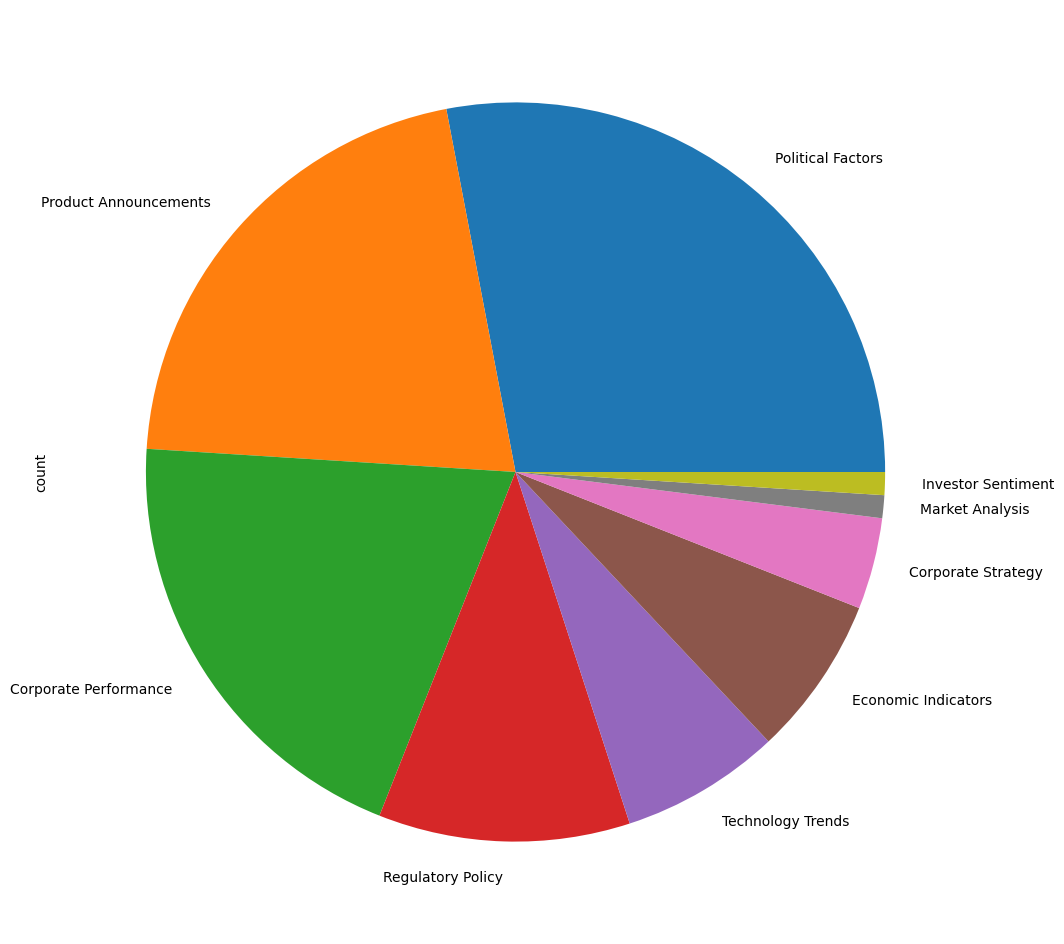

In [7]:
from adala.skills import ClassificationSkill

predictor = Agent(
    skills=LinearSkillSet(skills=[ClassificationSkill(labels={'label': labels})]),
    runtimes={
        'default': OpenAIChatRuntime(model='gpt-4-1106-preview', verbose=False)
    })

df_test = pd.DataFrame(data=ds['test'][:100]['text'], columns=['text'])

pred_test = predictor.run(df_test)
pred_test.label.value_counts().plot.pie(figsize=(12, 12))